In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/My Drive/Data" 
model_path = "/content/gdrive/My Drive/Models"

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [ ]:
data = pd.read_csv(data_path + "/ner_dataset.csv", encoding="latin1").fillna(method="ffill")

In [ ]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
class SentGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sents = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence:", self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentGetter(data)

In [ ]:
sents = [[col[0] for col in sent] for sent in getter.sents]
labels = [[col[2] for col in sent] for sent in getter.sents]

In [ ]:
print(sents[0])
print(labels[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
pip install transformers

     |████████████████████████████████| 1.3MB 9.4MB/s 
     |████████████████████████████████| 1.1MB 26.8MB/s 
     |████████████████████████████████| 890kB 14.7MB/s 
     |████████████████████████████████| 2.9MB 52.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a905f0ffc26d33527e42fc75db72d6da8ef5ab52a0bb4ccc2cf0e6a8a1018ede
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
MAX_LEN = 75
batch_size = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
def tokenize(sent, label):
    s_tokens = []
    l_tokens = []

    for cur_w, cur_l in zip(sent, label):
        w_tokens = tokenizer.tokenize(cur_w)
        s_tokens.extend(w_tokens)
        l_tokens.extend([cur_l] * len(w_tokens))

    return s_tokens, l_tokens

In [ ]:
tokenized_data = [tokenize(sent, label) for sent, label in zip(sents, labels)]

In [ ]:
s_tokens = [slpair[0] for slpair in tokenized_data]
l_tokens = [slpair[1] for slpair in tokenized_data]

In [ ]:
inp_ids = pad_sequences([tokenizer.convert_tokens_to_ids(s_token) for s_token in s_tokens], maxlen=MAX_LEN, dtype='long', value=0.0, truncating='post', padding='post')
out_ids = pad_sequences([[tag2idx.get(l) for l in l_token] for l_token in l_tokens], maxlen=MAX_LEN, dtype='long', value=tag2idx['PAD'], truncating='post', padding='post')

In [ ]:
att_masks = [[float(idx != 0.0) for idx in ids] for ids in inp_ids]

In [ ]:
train_inp, val_inp, train_out, val_out = train_test_split(inp_ids, out_ids, random_state=0, test_size=0.1)
train_masks, val_masks, _, _ = train_test_split(att_masks, inp_ids, random_state=0, test_size=0.1)

In [ ]:
train_inp = torch.tensor(train_inp)
val_inp = torch.tensor(val_inp)
train_out = torch.tensor(train_out)
val_out = torch.tensor(val_out)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(train_inp, train_masks, train_out)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inp, val_masks, val_out)
val_sampler = RandomSampler(val_data)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(tag2idx), output_attentions=False, output_hidden_states=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
def get_params(isFull):
  if isFull:
    params = [{'params': [p for n, p in list(model.named_parameters())], 'weight_decay_rate': 0.01}]
  else:
    params = [{'params': [p for n, p in list(model.classifier.named_parameters())]}]
  return params

In [ ]:
pip install seqeval

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=7e4d7be3d61dc1986e3ab737323c106e98fcdc00f1c783a72268767fec4a91fe
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(get_params(True), lr=3e-5, eps=1e-8)

In [ ]:
optimizer = AdamW(get_params(False), lr=3e-5, eps=1e-8)

In [ ]:
epochs = 4
max_norm = 1.0

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

In [ ]:
def train(model, optimizer, epochs, max_norm, name, best=float('inf')):
  train_losses, val_losses = [], []

  for _ in trange(epochs, desc="Epoch"):
    # Training
    model.train()
    train_loss = 0

    for batch in train_loader:
      batch = tuple(b.to(device) for b in batch)
      b_inp_ids, b_masks, b_out_ids = batch
      
      model.zero_grad()
      
      loss = model(b_inp_ids, token_type_ids=None, attention_mask=b_masks, labels=b_out_ids)[0]
      loss.backward()
      
      train_loss += loss.item()
      
      torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_norm)
      
      optimizer.step()
      scheduler.step()

    train_loss /= len(train_loader)
    print("Train loss:", train_loss)

    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    preds, outs = [], []
    for batch in val_loader:
      batch = tuple(b.to(device) for b in batch)
      b_inp_ids, b_masks, b_out_ids = batch

      with torch.no_grad():
          result = model(b_inp_ids, token_type_ids=None, attention_mask=b_masks, labels=b_out_ids)
      loss = result[0]
      logits = result[1].detach().cpu().numpy()
      b_out_ids = b_out_ids.cpu().numpy()

      val_loss += loss.item()
      preds.extend([list(p) for p in np.argmax(logits, axis=2)])
      outs.extend(b_out_ids)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print("Val loss:", val_loss)
    
    if val_loss < best:
      best = val_loss
      torch.save(model.state_dict(), model_path + "/NER" + name + ".pt")

    pred_tags = [[tag_values[p_i] for p_i, o_i in zip(p, o) if tag_values[o_i] != "PAD"] for p, o in zip(preds, outs)]
    out_tags = [[tag_values[o_i] for o_i in o if tag_values[o_i] != "PAD"] for o in outs]
    print("Val Accuracy:", accuracy_score(pred_tags, out_tags))
    print("Val F1-Score:", f1_score(pred_tags, out_tags))
    print()
  
  return train_losses, val_losses

In [ ]:
train(model, optimizer, epochs, max_norm, '')

In [ ]:
# 3e5 (epochs 0 - 3)



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.364264480178669
Val loss: 0.7693051373958588
Val Accuracy: 0.8001542889849278




Epoch:  25%|██▌       | 1/4 [06:10<18:32, 370.67s/it]

Val F1-Score: 0.014356053864863263

Train loss: 0.6782212215631074
Val loss: 0.5916863212982814
Val Accuracy: 0.8220118951830315




Epoch:  50%|█████     | 2/4 [12:20<12:20, 370.44s/it]

Val F1-Score: 0.15906848233668835

Train loss: 0.580367964360341
Val loss: 0.5343467589219412
Val Accuracy: 0.8387763058571749




Epoch:  75%|███████▌  | 3/4 [18:31<06:10, 370.55s/it]

Val F1-Score: 0.24891861761426978

Train loss: 0.5470767279436537
Val loss: 0.519175809820493
Val Accuracy: 0.8439109769147181




Epoch: 100%|██████████| 4/4 [24:40<00:00, 370.24s/it]

Val F1-Score: 0.27533973859603567



In [ ]:
# 3e5 (epochs 4 - 7)



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5423454060388372
Val loss: 0.5193149973948796
Val Accuracy: 0.8439109769147181




Epoch:  25%|██▌       | 1/4 [06:07<18:23, 367.88s/it]

Val F1-Score: 0.27533973859603567

Train loss: 0.542056714763811
Val loss: 0.5185647644599278
Val Accuracy: 0.8439109769147181




Epoch:  50%|█████     | 2/4 [12:16<12:16, 368.15s/it]

Val F1-Score: 0.27533973859603567

Train loss: 0.5426119365366943
Val loss: 0.5187000952164332
Val Accuracy: 0.8439109769147181




Epoch:  75%|███████▌  | 3/4 [18:23<06:07, 367.64s/it]

Val F1-Score: 0.27533973859603567

Train loss: 0.541787860413849
Val loss: 0.5188321365912756
Val Accuracy: 0.8439109769147181




Epoch: 100%|██████████| 4/4 [24:29<00:00, 367.43s/it]

Val F1-Score: 0.27533973859603567



In [ ]:
# 3e5_full (epochs 0 - 3)



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.18947950844481046
Val loss: 0.13385631422201794
Val Accuracy: 0.9574626927575424




Epoch:  25%|██▌       | 1/4 [06:35<19:46, 395.40s/it]

Val F1-Score: 0.8121617512921862

Train loss: 0.10934045837378838
Val loss: 0.12382011217375596
Val Accuracy: 0.961394573341186




Epoch:  50%|█████     | 2/4 [13:08<13:09, 394.70s/it]

Val F1-Score: 0.8260189972345797

Train loss: 0.08015845172394417
Val loss: 0.12426006462424993
Val Accuracy: 0.9629208729770309




Epoch:  75%|███████▌  | 3/4 [19:38<06:33, 393.19s/it]

Val F1-Score: 0.8365280289330922

Train loss: 0.06113559817805544
Val loss: 0.13188160275419553
Val Accuracy: 0.9623899861471717




Epoch: 100%|██████████| 4/4 [26:07<00:00, 391.79s/it]

Val F1-Score: 0.835568862275449



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(train_losses, 'b-o', label="train loss")
plt.plot(val_losses, 'r-o', label="val loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

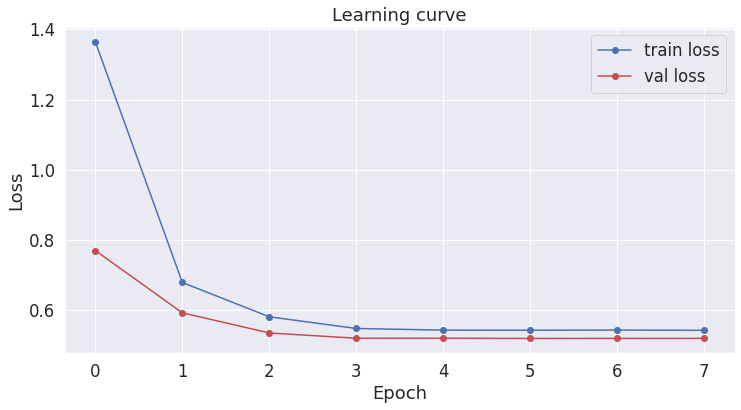

In [ ]:
# 3e5

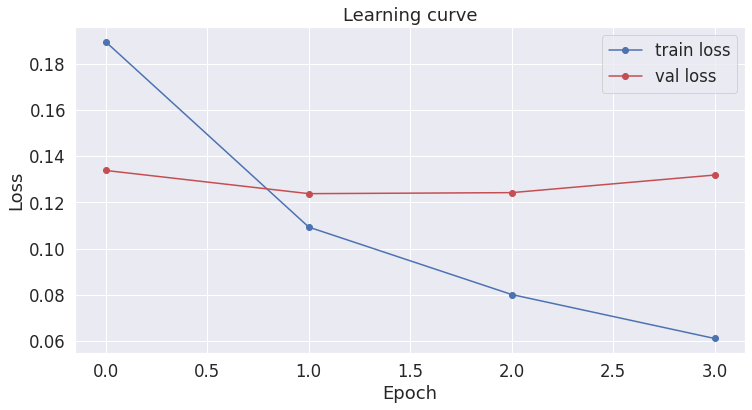

In [ ]:
# 3e5_full

In [ ]:
model.load_state_dict(torch.load(model_path + "/NER3e5_full.pt"))

<All keys matched successfully>

In [ ]:
def get_entities(sent):
  tokens = tokenizer.encode(sent)
  inp = torch.tensor([tokens]).cuda()
  
  model.eval()
  with torch.no_grad():
    logit = model(inp)
  
  pred = np.argmax(logit[0].cpu().numpy(), axis=2)
  tok = tokenizer.convert_ids_to_tokens(inp.cpu().numpy()[0])
  new_tok, new_lab = [], []
  
  for t, p in zip(tok, pred[0]):
    if t.startswith('##'):
      new_tok[-1] = new_tok[-1] + t[2:]
    else:
      new_tok.append(t)
      new_lab.append(tag_values[p])
  
  return new_tok, new_lab

In [ ]:
sent = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""

In [ ]:
for t, l in zip(*get_entities(sent)):
  print(l, '\t', t)

O 	 [CLS]
B-per 	 Mr
B-per 	 .
I-per 	 Trump
O 	 ’
O 	 s
O 	 tweets
O 	 began
O 	 just
O 	 moments
O 	 after
O 	 a
B-org 	 Fox
I-org 	 News
O 	 report
O 	 by
B-per 	 Mike
I-per 	 Tobin
O 	 ,
O 	 a
O 	 reporter
O 	 for
O 	 the
O 	 network
O 	 ,
O 	 about
O 	 protests
O 	 in
B-geo 	 Minnesota
O 	 and
O 	 elsewhere
O 	 .
O 	 [SEP]
